In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [5]:
class DBSCAN:
    """
    DBSCAN: Density-Based Spatial Clustering of Applications with Noise.

    Attributes:
        eps (float): The maximum distance between two samples for them to be considered
            neighbors.
        min_samples (int): The number of samples in a neighborhood for a point to be
            considered a core point.
    """
    def __init__(self, eps=0.5, min_samples=5):
        """
        Initializes the DBSCAN object.

        Args:
            eps (float, optional): The maximum distance between two samples. Defaults to 0.5.
            min_samples (int, optional): The number of samples in a neighborhood. Defaults to 5.
        """
        self.eps = eps
        self.min_samples = min_samples
        self.labels = None  # Cluster labels for each point; will be assigned during `fit`

    def fit(self, X):
        """
        Performs DBSCAN clustering on the data.

        Args:
            X (ndarray): The input data, shape (n_samples, n_features).
        """
        n_samples = X.shape[0]
        self.labels = np.full(n_samples, -1, dtype=int)  # Initialize all labels as -1 (noise)
        cluster_label = 0  # Start with cluster label 0

        for i in range(n_samples):
            if self.labels[i] != -1:  # If the point has already been processed, skip it
                continue

            # Find the neighbors of point i
            neighbors = self._get_neighbors(X, i)

            if len(neighbors) < self.min_samples:
                # Point i is not a core point; mark it as noise
                self.labels[i] = -1
                continue

            # Point i is a core point; start a new cluster
            self.labels[i] = cluster_label
            self._expand_cluster(X, neighbors, cluster_label)
            cluster_label += 1  # Move to the next cluster label

    def _expand_cluster(self, X, neighbors, cluster_label):
        """
        Expands the cluster starting from a core point.

        Args:
            X (ndarray): The input data, shape (n_samples, n_features).
            neighbors (list): A list of indices of the neighbors of the core point.
            cluster_label (int): The label of the current cluster.
        """
        i = 0
        while i < len(neighbors):
            j = neighbors[i]
            if self.labels[j] == -1:
                # Point j is not yet visited; assign it to the current cluster
                self.labels[j] = cluster_label
                new_neighbors = self._get_neighbors(X, j)
                if len(new_neighbors) >= self.min_samples:
                    # Point j is also a core point; add its neighbors to the queue
                    neighbors.extend(new_neighbors)
            elif self.labels[j] == 0:
                #if a neighbor is noise, change it to a border point
                self.labels[j] = cluster_label
            i += 1

    def _get_neighbors(self, X, i):
        """
        Finds the neighbors of a data point within a given radius (eps).

        Args:
            X (ndarray): The input data, shape (n_samples, n_features).
            i (int): The index of the data point.

        Returns:
            list: A list of indices of the neighbors of point i.
        """
        neighbors = []
        for j in range(X.shape[0]):
            if i != j and self._euclidean_distance(X[i], X[j]) <= self.eps:
                neighbors.append(j)
        return neighbors

    def _euclidean_distance(self, x1, x2):
        """
        Computes the Euclidean distance between two data points.

        Args:
            x1 (ndarray): The first data point, shape (n_features,).
            x2 (ndarray): The second data point, shape (n_features,).

        Returns:
            float: The Euclidean distance between x1 and x2.
        """
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def fit_predict(self, X):
        """
        Performs DBSCAN clustering on the data and returns cluster labels.
        This is a convenience method that combines fit() and a return of the labels_ attribute.

        Args:
            X (ndarray): The input data, shape (n_samples, n_features).

        Returns:
            ndarray: Cluster labels for each point, shape (n_samples,).
                   Label -1 indicates noise.
        """
        self.fit(X)
        return self.labels

In [9]:
df = pd.read_csv("cleaned_mlb_2022_full.csv")

# Choose swing-related features
swing_features = ['Swing%', 'Contact%', 'O-Swing%', 'Zone%']
X_swing = df[swing_features].dropna()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_swing)

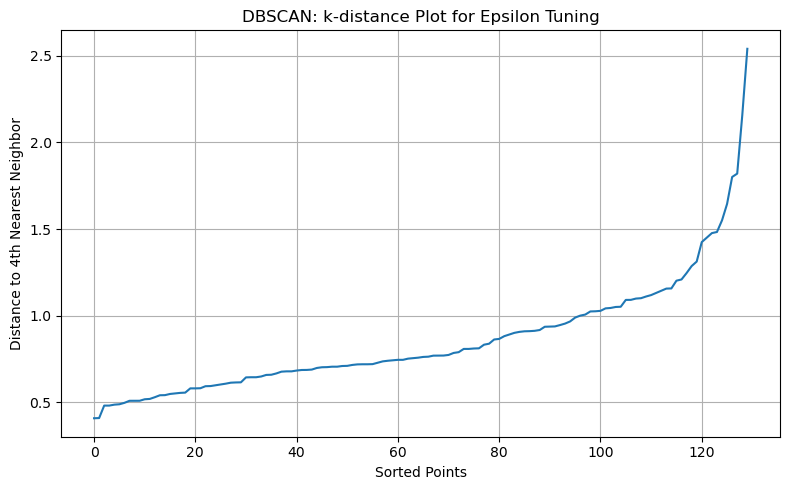

In [11]:
k = 4
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_scaled)
distances, indices = neigh.kneighbors(X_scaled)
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.xlabel("Sorted Points")
plt.ylabel(f"Distance to {k}th Nearest Neighbor")
plt.title("DBSCAN: k-distance Plot for Epsilon Tuning")
plt.grid(True)
plt.tight_layout()
plt.show()

The k-distance plot shows the distance to the 4th nearest neighbor for each hitter, sorted in ascending order. The curve begins relatively flat but bends sharply upward around a distance of 1.2, indicating a natural threshold where points become more isolated. This "elbow" suggests a good value for the eps hyperparameter, as it separates dense regions (clusters) from sparser ones (noise). Selecting eps = 1.2 helps capture the dense groupings without being too lenient on sparse outliers.

In [13]:
db = DBSCAN(eps=1.4, min_samples=5)
labels = db.fit_predict(X_scaled)

X_swing_result = X_swing.copy()
X_swing_result['Cluster'] = labels

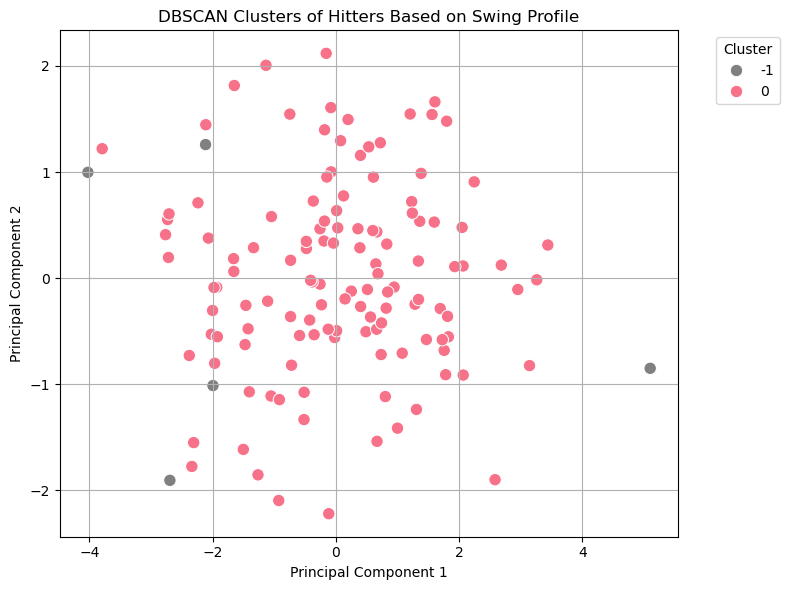

In [15]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_swing_result['PCA1'] = X_pca[:, 0]
X_swing_result['PCA2'] = X_pca[:, 1]

# Build palette with gray for noise (-1)
unique_labels = sorted(set(labels))
palette = sns.color_palette('husl', len(unique_labels) - (1 if -1 in unique_labels else 0))
if -1 in unique_labels:
    palette = [(0.5, 0.5, 0.5)] + palette
label_color_dict = {label: palette[i] for i, label in enumerate(unique_labels)}

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=X_swing_result,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette=label_color_dict,
    s=80,
    legend='full'
)
plt.title("DBSCAN Clusters of Hitters Based on Swing Profile")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

This PCA-reduced scatter plot shows the DBSCAN clustering results for hitters, using swing metrics like O-Swing%, Z-Swing%, and Contact%. Nearly all points are grouped into a single cluster (labeled 0 in pink), with a few outliers (black dots, labeled -1) identified as noise. The lack of multiple distinct clusters suggests the majority of hitters share similar swing tendencies, or that swing style differences may be more gradual and continuous rather than clearly segmented. The separation of just a few players implies they might have unorthodox approaches or rare combinations of swing discipline and contact ability.

In [17]:
X_swing_result['Cluster'].value_counts()

Cluster
 0    125
-1      5
Name: count, dtype: int64

The cluster label count confirms that DBSCAN formed only one main cluster containing 125 hitters, while marking 5 hitters as noise. This reinforces the visual observation from the PCA plot: most hitters were grouped together, and very few deviated far enough to be considered separate or anomalous. While DBSCAN is typically effective for finding non-spherical and organically shaped clusters, in this case the data's density did not support meaningful subgroups beyond a dominant cluster.

Despite DBSCAN’s strength in identifying clusters of arbitrary shape, its performance here indicates that hitters' swing profiles in 2022 were largely homogeneous, at least within the chosen feature space. The k-distance plot justified a reasonable eps selection, but the resulting model still grouped nearly all hitters into a single cluster, suggesting either a true lack of natural segmentation or the need for a richer feature set to uncover subtler behavioral clusters. While the method was successful in flagging a few outliers, K-means may offer more interpretable groupings in this context. Alternatively, adding more features, like whiff%, chase rate, or zone contact by pitch type, might allow DBSCAN to better differentiate swing archetypes.